In [63]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [64]:
# Read file
data = pd.read_csv("./consumption_temp.csv")
# Convert datatypes
data["time"] = pd.to_datetime(data["time"])
data["consumption"] = pd.to_numeric(data["consumption"])
data["temperature"] = pd.to_numeric(data["temperature"])

# Filter away helsingfors with less than 4.5 in consumption as it seems like noise.
mask = (data["location"]!= "helsingfors") | ((data["location"] == "helsingfors"))
data = data[mask]

# Split into seperate dataframes for each city
data_cities = {location: data[data["location"] == location] for location in data["location"].unique()}


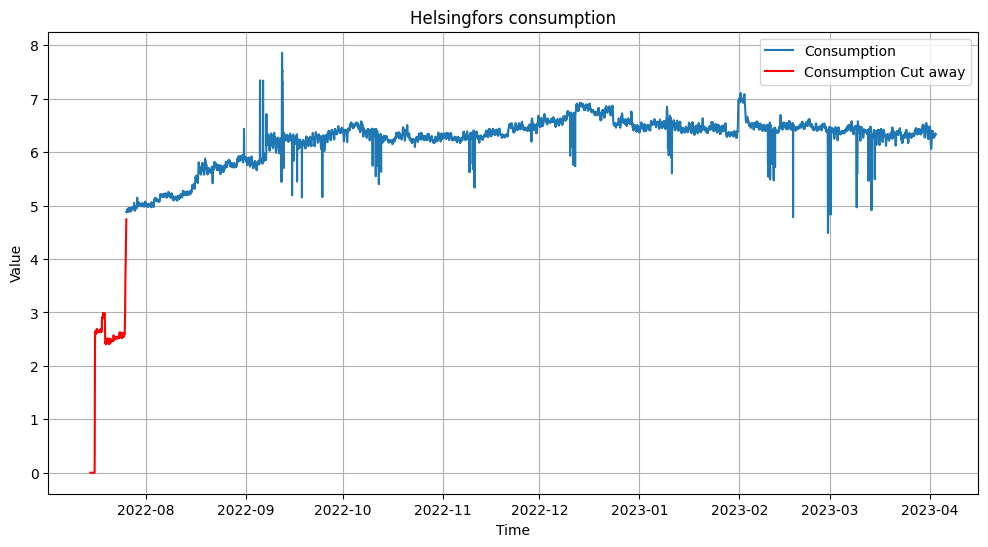

Timestamp('2022-07-14 21:00:00')

In [76]:
#plot helsingfors
plt.figure(figsize=(12, 6))  # Set the figure size (adjust as needed)
helsingfors_cut = data[(data['location']=='helsingfors') & (data["time"] <= "2022-07-26 00:00:00")]

helsingfors_keep = data[(data['location']=='helsingfors') & (data["time"] > "2022-07-26 00:00:00")]

plt.plot(helsingfors_keep['time'], helsingfors_keep['consumption'], label='Consumption', linestyle='-')
plt.plot(helsingfors_cut['time'], helsingfors_cut['consumption'], label='Consumption Cut away', linestyle='-', color="red")
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Helsingfors consumption')
plt.legend()
plt.grid(True)

plt.show()
data[data['location']=='helsingfors']['time'].min()

In [22]:
normalize_features = True

# Plot
# for city, city_data in data_cities.items():

#     # Normalize the "consumption" and "temperature" columns using Min-Max scaling
#     min_consumption = city_data['consumption'].min()
#     max_consumption = city_data['consumption'].max()
#     min_temperature = city_data['temperature'].min()
#     max_temperature = city_data['temperature'].max()

#     normalized_city_data = city_data.copy()
#     if normalize_features:
#         normalized_city_data['consumption'] = (city_data['consumption'] - min_consumption) / (max_consumption - min_consumption)
#         normalized_city_data['temperature'] = 1 - ((city_data['temperature'] - min_temperature) / (max_temperature - min_temperature))
    

#     # Print correlation matrix
#     print(f"Correlation: {normalized_city_data.drop(columns=['location', 'time']).corr()}")
#     # Plot
#     plt.figure(figsize=(12, 6))  # Set the figure size (adjust as needed)

#     plt.plot(normalized_city_data['time'], normalized_city_data['consumption'], label='Consumption', linestyle='-')
#     plt.plot(normalized_city_data['time'], normalized_city_data['temperature'], label='Temperature inverse', linestyle='-')

#     plt.xlabel('Time')
#     plt.ylabel('Value')
#     plt.title(city)
#     plt.legend()
#     plt.grid(True)

#     plt.show()

# Remove outliers

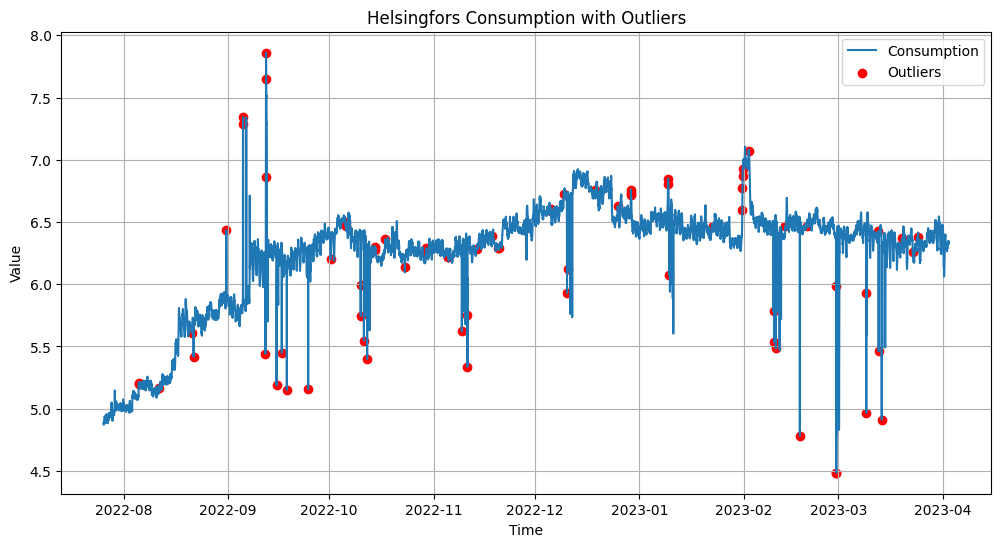

In [77]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Read file and preprocess
data = pd.read_csv("./consumption_temp.csv")
data["time"] = pd.to_datetime(data["time"])
data["consumption"] = pd.to_numeric(data["consumption"])
data["temperature"] = pd.to_numeric(data["temperature"])
mask = (data["location"] != "helsingfors") | ((data["location"] == "helsingfors")  & (data["time"] > "2022-07-26 00:00:00"))
data = data[mask]

# Function to find outliers
def find_outliers(ts, window=30, sigma=3):
    rolling_mean = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    outliers = np.abs(ts - rolling_mean) > (sigma * rolling_std)
    return outliers

# Plotting
for location in ["helsingfors"]: #data["location"].unique():
    city_data = data[data["location"] == location]
    city_data = city_data.set_index('time')

    # Seasonal decomposition
    decomposition = seasonal_decompose(city_data['consumption'], model='additive', period=365)
    residuals = decomposition.resid.dropna()

    # Find outliers
    outliers = find_outliers(residuals)

    plt.figure(figsize=(12, 6))
    plt.plot(city_data['consumption'], label='Consumption', linestyle='-')
    plt.scatter(city_data.loc[outliers.index[outliers], 'consumption'].index, 
                city_data.loc[outliers.index[outliers], 'consumption'], 
                color='red', label='Outliers')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'{location.capitalize()} Consumption with Outliers')
    plt.legend()
    plt.grid(True)
    plt.show()

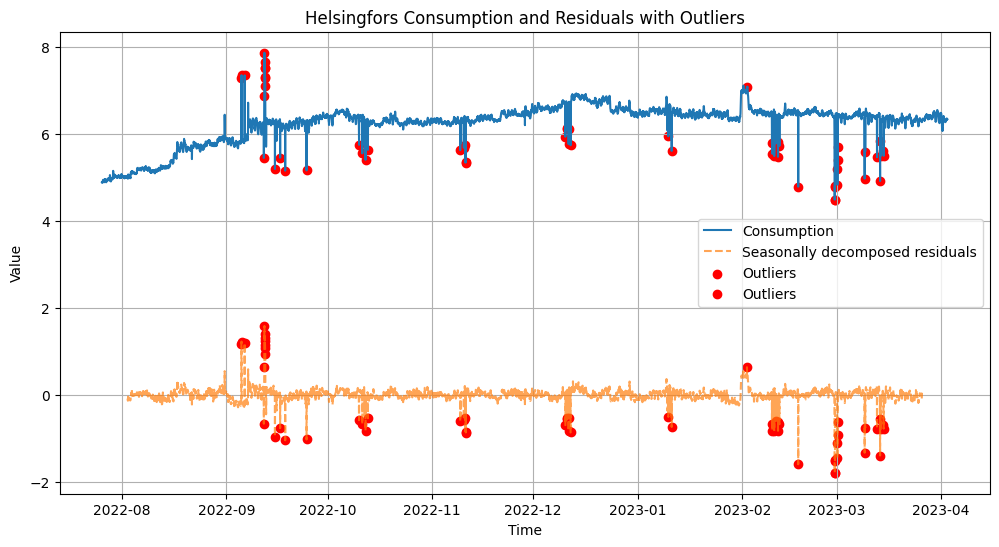

In [107]:
# Function to find outliers
def find_outliers(ts, window=40, sigma=4):
    rolling_mean = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    outliers = np.abs(ts - rolling_mean) > (sigma * rolling_std)
    return outliers

# Plotting
for location in ["helsingfors"]:  # data["location"].unique():
    city_data = data[data["location"] == location]
    city_data = city_data.set_index('time')

    # Seasonal decomposition
    # decomposition = seasonal_decompose(city_data['consumption'], model='additive', period=365)
    decomposition = seasonal_decompose(city_data['consumption'], model='additive', period=30)
    
    # residuals = decomposition.resid.dropna()
    resuduals = decomposition.resid

    # Find outliers
    # outliers = find_outliers(residuals)
    outliers = (residuals>0.6) | (residuals<-0.5)

    plt.figure(figsize=(12, 6))
    plt.plot(city_data['consumption'], label='Consumption', linestyle='-')
    plt.plot(residuals, label='Seasonally decomposed residuals', linestyle='--', alpha=0.7)
    plt.scatter(city_data.loc[outliers.index[outliers], 'consumption'].index, 
                city_data.loc[outliers.index[outliers], 'consumption'], 
                color='red', label='Outliers', marker='o')
    plt.scatter(residuals.loc[outliers.index[outliers]].index, 
                residuals.loc[outliers.index[outliers]], 
                color='red', label='Outliers', marker='o')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'{location.capitalize()} Consumption and Residuals with Outliers')
    plt.legend()
    plt.grid(True)
    plt.show()